# Capstone Project Flask UI

Pada capstone ini, anda diminta untuk membangun sebuah UI sederhana menggunakan **Flask** yang berisi beberapa tampilan plot dari skeleton yang sudah disediakan dan satu plot tambahan berdasarkan analisis anda.

File ini dapat dimanfaatkan untuk membantu anda dalam proses wrangling dan visualization. Apabila proses wrangling sudah tepat dan hasil visualisasi sudah sesuai dengan ketentuan, anda dapat memindahkan kembali kode program yang sudah anda lengkapi ke dalam file `app.py`.

## Create Virtual Enviroment 

**1. Buat virtual environment bernama `capstone-flask`**

Hal pertama yang harus dilakukan adalah melakukan pengaturan environment conda. Untuk menyiapkan conda environment dan kernel, silahkan gunakan command berikut:

```
conda create -n capstone-flask python=3.10
conda activate capstone-flask
```
<br>

**2. Install library yang dibutuhkan: `pandas`, `flask`, `matplotlib`, dan `numpy`**

Seluruh dependecies telah di-export ke dalam file requirements.txt. Oleh karena itu untuk melakukan instalasi library, Anda dapat menggunakan perintah berikut:

```
pip install -r requirements.txt --user
```
<br>


## Data Preprocessing

**Import library**

In [38]:
from flask import Flask, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

**Load data**

Silahkan read file `googleplaystore.csv` dalam bentuk dataframe dan simpan pada variabel `playstore`

In [39]:
playstore = pd.read_csv('data/googleplaystore.csv')

**Data Cleansing** 

**_Task 1:_** Hapus data duplikat berdasarkan kolom App, dengan tetap keep data pertama (hint : gunakan parameter subset)

In [40]:
playstore = playstore.drop_duplicates(subset='App', keep='first') 

Silahkan jalankan code berikut ini untuk menghapus data baris 10472 karena nilai pada baris tersebut tidak tersimpan pada kolom yang benar (**tidak perlu diubah**)

In [42]:
playstore.loc[[10472]]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [5]:
playstore = playstore.drop([10472])

**_Task 2:_** Cek tipe data kolom Category. Jika masih tersimpan dengan format tipe data yang salah, ubah ke tipe data yang sesuai


In [43]:
playstore['Category'] = playstore['Category'].astype('category')

**_Task 3:_** Pada kolom `Installs`, buang tanda koma (,) dan tanda tambah (+) kemudian ubah tipe data menjadi integer

In [44]:
playstore.Installs = playstore.Installs.apply(lambda x: x.replace(',',''))
playstore.Installs = playstore.Installs.apply(lambda x: x.replace('+',''))

Silahkan jalankan code berikut ini untuk merapikan kolom Size, Anda tidak perlu mengubah apapun di bagian ini

In [47]:
# Mengganti 'Varies with device' dengan NaN
playstore['Size'].replace('Varies with device', np.nan, inplace=True)

# Menghapus tanda koma dan tanda tambah dari kolom Size
playstore['Size'] = playstore['Size'].str.replace(',', '').str.replace('+', '')

# Mengonversi Size dari format string ke float
playstore.Size = (playstore.Size.replace(r'[kM]+$', '', regex=True).astype(float) *
                  playstore.Size.str.extract(r'[\d\.]+([kM]+)', expand=False)
                  .fillna(1)
                  .replace(['k', 'M'], [10**3, 10**6]).astype(int))

# Mengisi nilai NaN dengan rata-rata ukuran dalam kategori masing-masing
playstore['Size'].fillna(playstore.groupby('Category')['Size'].transform('mean'), inplace=True)

/var/folders/0n/pbf8qp0x6hqfbq434f8v1xjm0000gn/T/ipykernel_30600/278030195.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  playstore['Size'] = playstore['Size'].str.replace(',', '').str.replace('+', '')


**_Task 4:_** Pada kolom `Price`, buang karakter $ pada nilai `Price` lalu ubah tipe datanya menjadi float

In [49]:
# Hanya menyimpan baris di mana Price berisi karakter numerik setelah menghapus tanda '$'
playstore = playstore[playstore['Price'].str.contains(r'^\$?\d+\.?\d*$', na=False)]

# Menghapus tanda dolar dan mengonversi ke float
playstore['Price'] = playstore['Price'].apply(lambda x: x.replace('$',''))
playstore['Price'] = playstore['Price'].astype('float64')

Ubah tipe data `Reviews` dan `Size` ke dalam tipe data integer

In [28]:
playstore[['Reviews','Size','Installs']] = playstore[['Reviews','Size','Installs']].astype('int64')
playstore.dtypes

App                 object
Category          category
Rating             float64
Reviews              int64
Size                 int64
Installs             int64
Type                object
Price              float64
Content Rating      object
Genres              object
Last Updated        object
Current Ver         object
Android Ver         object
dtype: object

## Data Wrangling

In [50]:
df2 = playstore.copy()

**_Task 5:_** Dataframe top_category dibuat untuk menyimpan frekuensi aplikasi untuk setiap data pada kolom `Category`. 

1. Gunakan `crosstab` untuk menghitung frekuensi aplikasi di setiap category
2. Berikan nama `Jumlah` sebagai nama kolom
3. Urutkan nilai frekuensi dari nilai yang paling besar ke paling kecil. 
4. Reset index dari dataframe `top_category`.

In [51]:
top_category = pd.crosstab(
    index = df2.Category,
    columns = 'Jumlah'
    ).sort_values(by='Jumlah', ascending=False).reset_index()
top_category.head()

col_0,Category,Jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395


In [52]:
top_category.head()

col_0,Category,Jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395


**_Task 6:_** Ini adalah bagian untuk melengkapi konten value box 
- Isi `most_categories` dengan nama `Category` dengan frekuensi terbanyak mengacu pada dataframe `top_category`
- isi `total` dengan nilai frekuensi dari `Category` terbanyak mengacu pada dataframe `top_category`

In [53]:
most_categories = top_category.transpose().iloc[0,0]
total = top_category.iloc[0,1]

`rev_table` adalah tabel yang berisi 10 aplikasi yang paling banyak direview oleh pengguna.

Silahkan melakukan proses yang tepat untuk menampilkan 10 aplikasi dengan jumlah Review pengguna terbanyak. Tabel yang ditampilkan terdiri dari 4 kolom yaitu nama `Category`, nama `App`, jumlah `Reviews`, dan nilai `Rating`.


In [55]:
# Konversi kolom 'Reviews' menjadi numerik, mengabaikan nilai yang tidak bisa dikonversi
df2['Reviews'] = pd.to_numeric(df2['Reviews'], errors='coerce')

# Menghapus baris dengan nilai NaN di kolom 'Reviews' setelah konversi
df2 = df2.dropna(subset=['Reviews'])

# Pastikan 'Reviews' sudah berupa integer
df2['Reviews'] = df2['Reviews'].astype(int)

# Setelah membersihkan data, coba kembali untuk melakukan pengelompokan, pengurutan, dan pemilihan 10 aplikasi teratas
rev_table = (df2.groupby(['Category', 'App'])
       .agg({'Reviews':'sum','Rating':'mean'})
       ).sort_values(by='Reviews', ascending=False).head(10).reset_index().round(1)

# Menampilkan tabel hasilnya
rev_table

,Category,App,Reviews,Rating
0,SOCIAL,Facebook,78158306,4.1
1,COMMUNICATION,WhatsApp Messenger,69119316,4.4
2,SOCIAL,Instagram,66577313,4.5
3,COMMUNICATION,Messenger – Text and Video Chat for Free,56642847,4.0
4,GAME,Clash of Clans,44891723,4.6
5,TOOLS,Clean Master- Space Cleaner & Antivirus,42916526,4.7
6,GAME,Subway Surfers,27722264,4.5
7,VIDEO_PLAYERS,YouTube,25655305,4.3
8,TOOLS,"Security Master - Antivirus, VPN, AppLock, Boo...",24900999,4.7
9,GAME,Clash Royale,23133508,4.6


Apabila menuliskan kode program yang tepat maka hasil wrangling adalah sebagai berikut :

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Category</th>
      <th>App</th>
      <th>Reviews</th>
      <th>Rating</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>SOCIAL</td>
      <td>Facebook</td>
      <td>78158306</td>
      <td>4.1</td>
    </tr>
    <tr>
      <th>1</th>
      <td>COMMUNICATION</td>
      <td>WhatsApp Messenger</td>
      <td>69119316</td>
      <td>4.4</td>
    </tr>
    <tr>
      <th>2</th>
      <td>SOCIAL</td>
      <td>Instagram</td>
      <td>66577313</td>
      <td>4.5</td>
    </tr>
    <tr>
      <th>3</th>
      <td>COMMUNICATION</td>
      <td>Messenger – Text and Video Chat for Free</td>
      <td>56642847</td>
      <td>4.0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>GAME</td>
      <td>Clash of Clans</td>
      <td>44891723</td>
      <td>4.6</td>
    </tr>
    <tr>
      <th>5</th>
      <td>TOOLS</td>
      <td>Clean Master- Space Cleaner &amp; Antivirus</td>
      <td>42916526</td>
      <td>4.7</td>
    </tr>
    <tr>
      <th>6</th>
      <td>GAME</td>
      <td>Subway Surfers</td>
      <td>27722264</td>
      <td>4.5</td>
    </tr>
    <tr>
      <th>7</th>
      <td>VIDEO_PLAYERS</td>
      <td>YouTube</td>
      <td>25655305</td>
      <td>4.3</td>
    </tr>
    <tr>
      <th>8</th>
      <td>TOOLS</td>
      <td>Security Master - Antivirus, VPN, AppLock, Boo...</td>
      <td>24900999</td>
      <td>4.7</td>
    </tr>
    <tr>
      <th>9</th>
      <td>GAME</td>
      <td>Clash Royale</td>
      <td>23133508</td>
      <td>4.6</td>
    </tr>
  </tbody>
</table>
</div>

## Data Visualization

**Membuat Bar Plot**

**_Task 7:_** 
Lengkapi tahap agregasi untuk membuat dataframe yang mengelompokkan jumlah aplikasi berdasarkan Category. Buatlah bar plot dengan ketentuan:
- axis **`y`** adalah nama `Category`
- axis **`x`** adalah jumlah aplikasi pada setiap kategori yang telah diurutkan dari jumlah terbanyak

Apabila menuliskan kode program yang tepat, maka akan menghasilkan visualisasi sebagai berikut: 
<br><br>
![cat_order.png](cat_order.png)

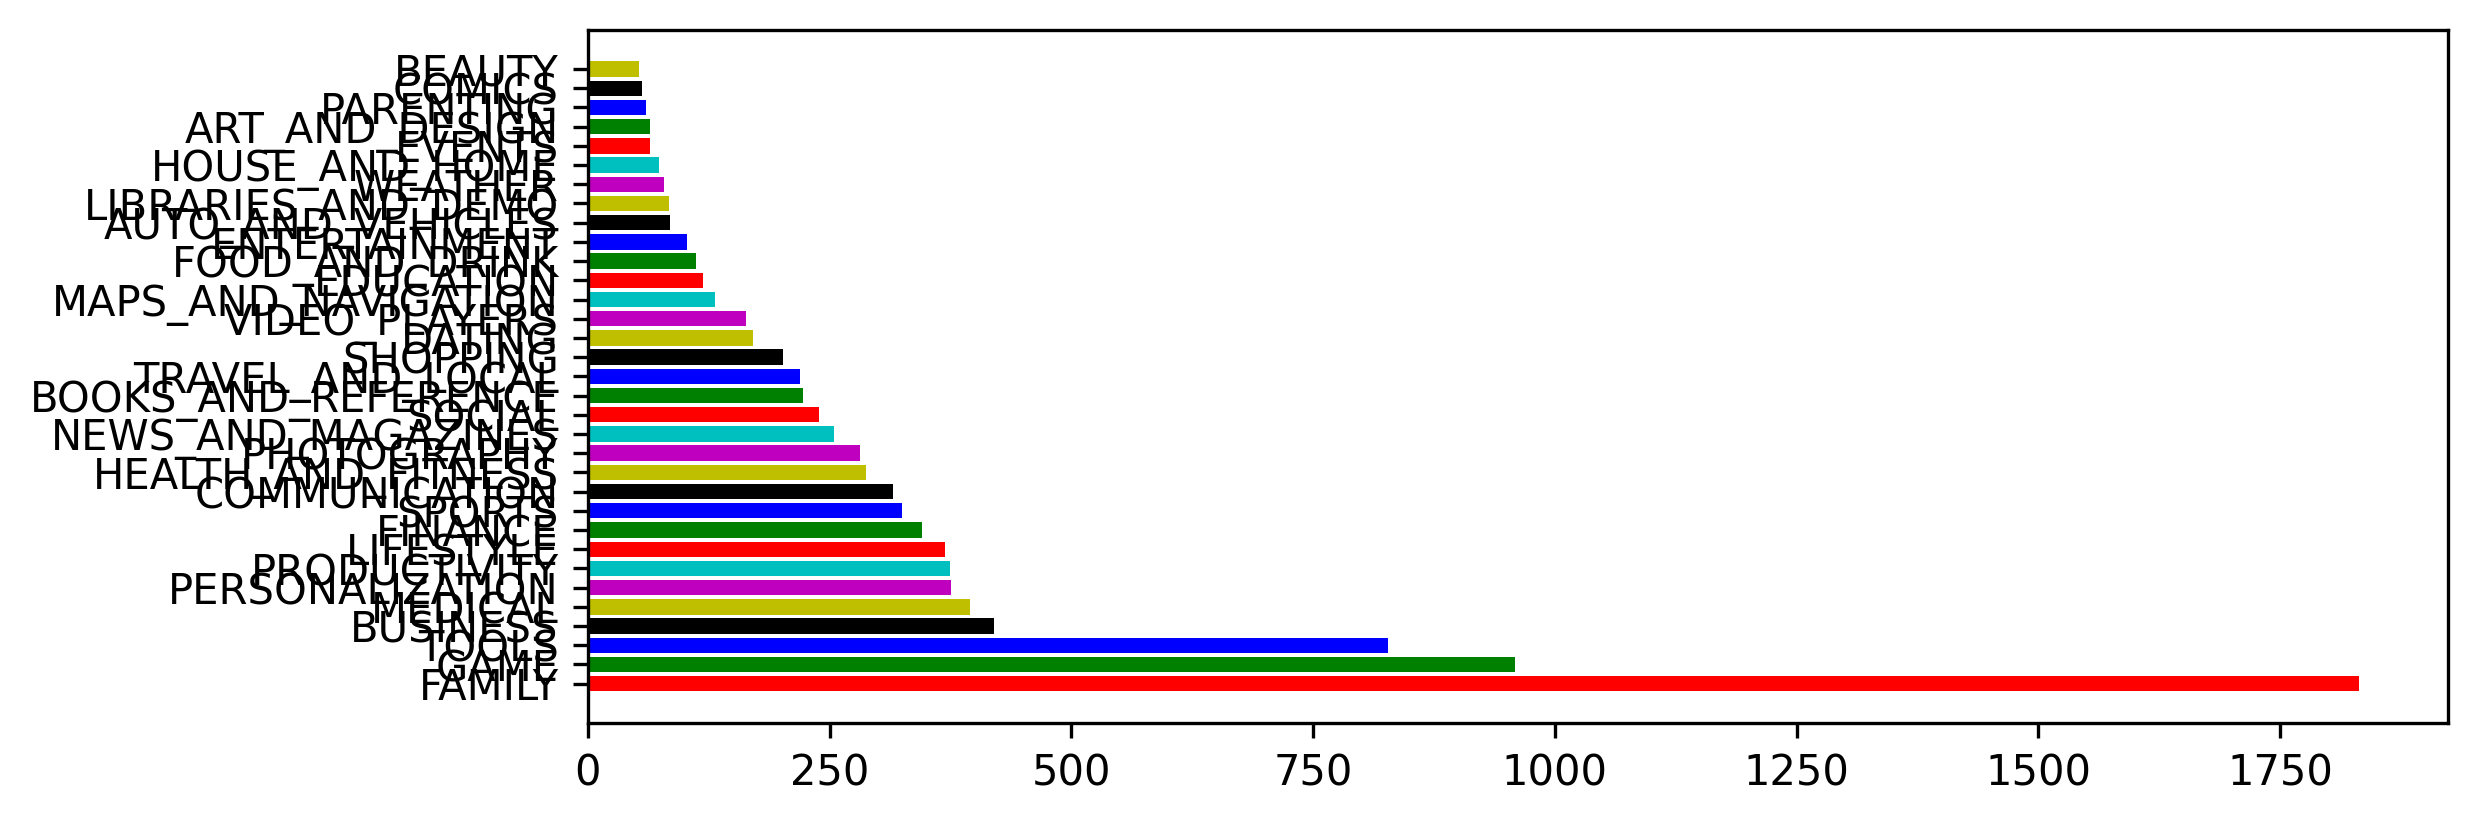

In [16]:
# Tahap agregasi untuk membuat dataframe yang mengelompokkan jumlah aplikasi berdasarkan Category
cat_order = df2.groupby('Category').agg({
    'App': 'count'
}).rename({'App': 'Total'}, axis=1).sort_values(by='Total', ascending=False)

# Menyusun data untuk sumbu X dan Y
X = cat_order['Total']
Y = cat_order.index

my_colors = ['r','g','b','k','y','m','c']

# Membuat kanvas/figure
fig = plt.figure(figsize=(8,3), dpi=300)
fig.add_subplot()

# Membuat bar plot horizontal
plt.barh(y=Y, width=X, color=my_colors)

# Menyimpan plot dalam format image.png
plt.savefig('cat_order.png', bbox_inches="tight")

**Membuat Scatter Plot**

**_Task 8:_** Buatlah scatter plot untuk menampilkan hubungan dan persebaran apalikasi dilihat dari Review vs Rating. Kemudian, ubah ukuran tiap lingkaran pada scatter plot sehingga dapat menggambarkan berapa banyak pengguna yang telah menginstall aplikasi

Apabila menuliskan kode program yang tepat, maka akan menghasilkan visualisasi sebagai berikut: 
<br><br>

![rev_rat.png](rev_rat.png)

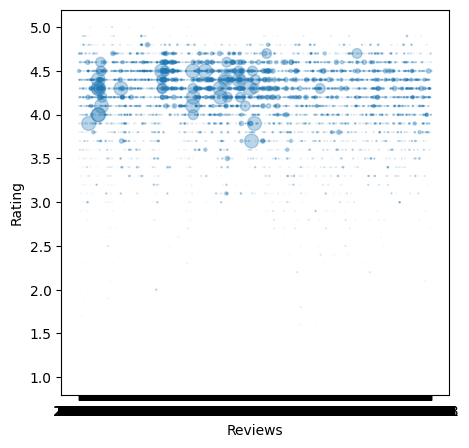

In [17]:
# Menyusun data untuk sumbu X, Y, dan ukuran lingkaran
X = df2['Reviews'].values  # axis x
Y = df2['Rating'].values   # axis y
area = df2['Installs'].values / 10000000  # ukuran besar/kecilnya lingkaran scatter plot

# Membuat kanvas/figure
fig = plt.figure(figsize=(5,5))
fig.add_subplot()

# Membuat scatter plot
plt.scatter(x=X, y=Y, s=area, alpha=0.3)
plt.xlabel('Reviews')
plt.ylabel('Rating')

# Menyimpan plot dalam format image.png
plt.savefig('rev_rat.png', bbox_inches="tight")

**Membuat Histogram Size Distribution**

**_Task 9:_** Buatlah sebuah histogram yang menggambarkan distribusi Size aplikasi dalam satuan Mb(Megabytes). Histogram yang terbentuk terbagi menjadi 100 bins

Apabila menuliskan kode program yang tepat, maka akan menghasilkan visualisasi sebagai berikut: 
<br><br>
![hist_size.png](hist_size.png)

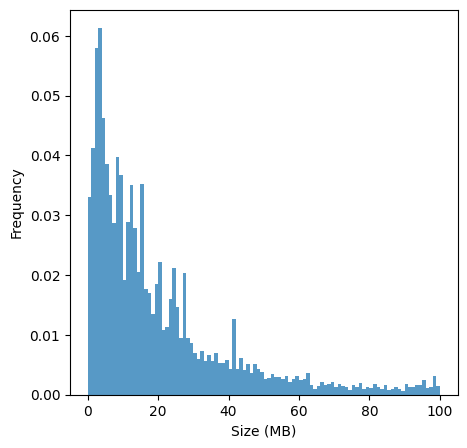

In [18]:
# Mengonversi ukuran dari bytes ke Megabytes
X = (df2['Size'] / 1000000).values

# Membuat kanvas/figure
fig = plt.figure(figsize=(5,5))
fig.add_subplot()

# Membuat histogram dengan 100 bins
plt.hist(X, bins=100, density=True, alpha=0.75)
plt.xlabel('Size (MB)')
plt.ylabel('Frequency')

# Menyimpan plot dalam format image.png
plt.savefig('hist_size.png', bbox_inches="tight")

**_Task 10:_** Buatlah plot berdasarkan hasil analisis anda. Plot yang dibuat tidak diperbolehkan sama dengan plot yang sudah dicontohkan.

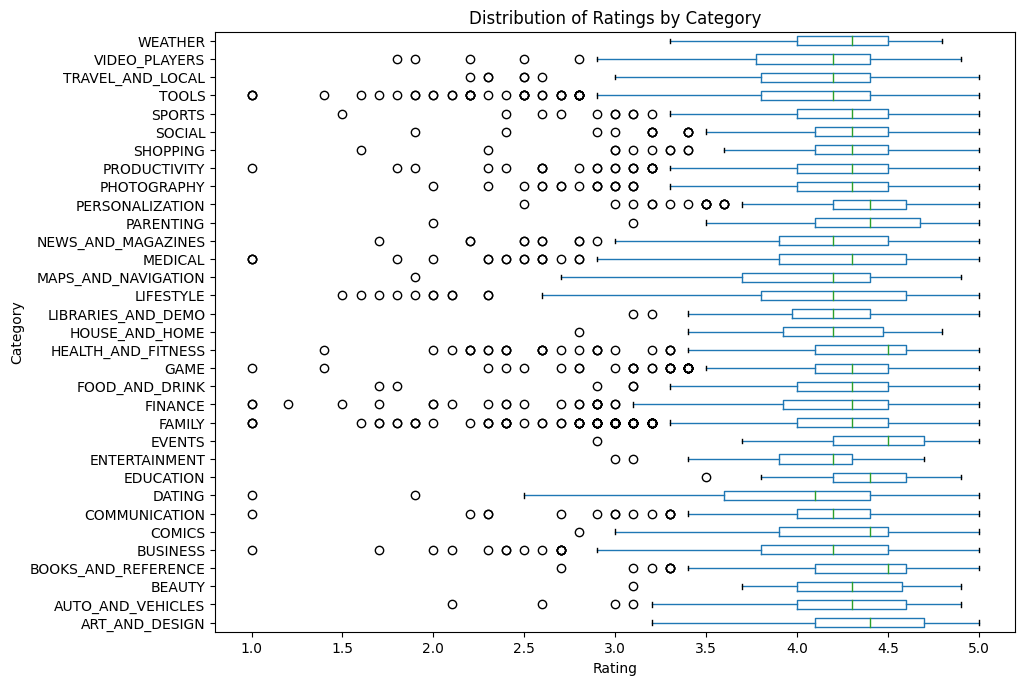

In [19]:
## code here
# Membuat kanvas/figure
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

# Membuat box plot dari Rating berdasarkan Category menggunakan matplotlib
df2.boxplot(column='Rating', by='Category', ax=ax, vert=False, grid=False)

# Menambahkan judul dan label sumbu
plt.title('Distribution of Ratings by Category')
plt.suptitle('')  # Menghilangkan title default dari pandas boxplot
plt.xlabel('Rating')
plt.ylabel('Category')

# Menyimpan plot dalam format image.png
plt.savefig('boxplot_rating_category.png', bbox_inches="tight")